![alt text](https://moodle.msengineering.ch/pluginfile.php/1/core_admin/logo/0x150/1643104191/logo-mse.png "MSE Logo") 
![alt text](https://www.hes-so.ch/typo3conf/ext/wng_site/Resources/Public/HES-SO/img/logo_hesso_master_tablet.svg "Hes Logo")

# WEB MINING PROJET AIRBNB
## L'objectif
Dans la première partie, l'objectif de ce notebook est de clusteriser les régions en fonction de leur moyenne de réduction de prix. Dans la deuxième partie, nous effectuons la visualisation sur une carte. Notre but est d'examiner les différences de réduction entre les régions et d'en tirer des inférences. Ensuite, nous créons deux fichiers HTML contenant les visualisations sur la carte. Ces codes sont également utilisés pour créer une interface en ligne avec Streamlit.

In [3]:
pip install streamlit folium streamlit-folium pandas scikit-learn


  Using cached altair-5.3.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ---------------------------------------- 0.0/8.6 MB ? eta -:--:--
   - -------------------------------------- 0.4/8.6 MB 10.9 MB/s eta 0:00:01
   --- ------------------------------------ 0.8/8.6 MB 7.3 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.6 MB 9.4 MB/s eta 0:00:01
   ---------- ----------------------------- 2.3/8.6 MB 9.9 MB/s eta 0:00:01
   -------------- ------------------------- 3.2/8.6 MB 10.8 MB/s eta 0:00:01
   ------------------ --------------------- 4.1/8.6 MB 11.2 MB/s eta 0:00:01
   ---------------------

In [1]:
import pandas as pd
file_path = "C:/Users/Abdi/Desktop/web_min_juin_24_projet/total_out_clean.csv"
data = pd.read_csv(file_path)
data.head()


,Unnamed: 0,price,old_price,Type,pays,region,voyageurs,rooms,bed,bathroom,period_start,period_end,new_rating
0,0,2920.0,6084.0,cottage,Espagne,Madrid,9,3,8,2,2024-07-31,2024-08-31,4.97
1,1,1500.0,1705.0,hébergement,Espagne,Trevélez,2,1,1,1,2024-07-31,2024-08-31,4.89
2,2,1968.0,3280.0,loft,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.81
3,3,2353.0,2870.0,loft,Espagne,Séville,4,2,3,1,2024-07-31,2024-08-31,4.96
4,4,2129.0,2505.0,appartement,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.83


### Clustering des régions par le prix de réduction.

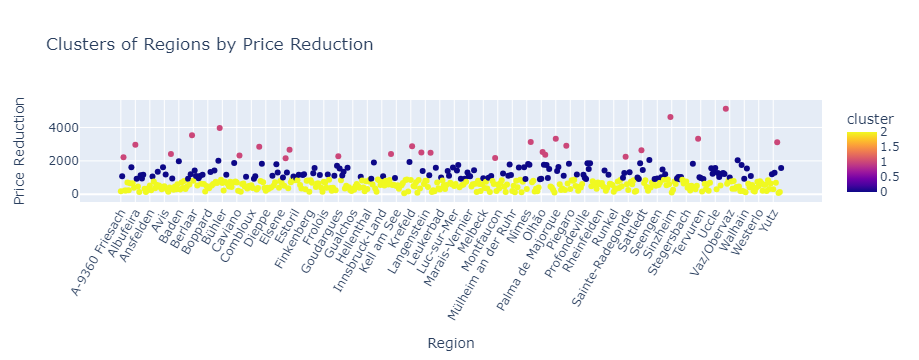

                                  region  price_reduction  cluster
0                        A-9360 Friesach            186.0        2
1                             Aartselaar           1079.0        0
2                           Aci Castello           2212.0        1
3                                  Ahorn            223.0        2
4                                   Aich            228.0        2
..                                   ...              ...      ...
497                            Zirkitzen            697.0        2
498                               Zürich           3112.0        1
499  car/caravane - Carrazeda de Ansiães             84.0        2
500  car/caravane - Francfort-sur-l'Oder            143.5        2
501                               Érezée           1569.0        0

[502 rows x 3 columns]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Calculer la réduction de prix pour chaque entrée
data['price_reduction'] = data['old_price'] - data['price']

# Calculer la réduction moyenne de prix par région
region_reduction = data.groupby('region')['price_reduction'].mean().reset_index()

# Normaliser les données de réduction de prix
scaler = StandardScaler()
region_reduction_normalized = scaler.fit_transform(region_reduction[['price_reduction']])

# Appliquer le clustering K-Means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
region_clusters = kmeans.fit_predict(region_reduction_normalized)

# Ajouter les informations de cluster au DataFrame
region_reduction['cluster'] = region_clusters

import plotly.express as px

fig = px.scatter(region_reduction, x='region', y='price_reduction', color='cluster', title='Clusters of Regions by Price Reduction',
                 labels={'region': 'Region', 'price_reduction': 'Price Reduction'}, hover_data=['region'])
fig.update_layout(xaxis_tickangle=-60, showlegend=True)
fig.show()

print(region_reduction)


### Création d'un fichier csv pour garder les coordonnées géographique

In [ ]:
from geopy.geocoders import Nominatim
import time

# les noms des régions uniques
regions = data['region'].unique()

#  geopy pour obtenir les coordonnées géographiques
geolocator = Nominatim(user_agent="geoapiExercises")
coordinates = []

for region in regions:
    try:
        location = geolocator.geocode(region)
        if location:
            coordinates.append((region, location.latitude, location.longitude))
        else:
            coordinates.append((region, None, None))
        time.sleep(1)  
    except Exception as e:
        coordinates.append((region, None, None))
        print(f"Erreur pour la région {region}: {e}")

# DataFrame avec les coordonnées
coords_df = pd.DataFrame(coordinates, columns=['region', 'latitude', 'longitude'])
coords_df.to_csv('C:/Users/Abdi/Desktop/web_min_juin_24_projet/regions_coordinates.csv', index=False)
coords_df.head()


### Afficher les top 10 regions en fonction du prix de réductionn sur la carte 

In [6]:
#  10 régions avec les plus grandes réductions de prix pour chaque pays
top_regions_per_country = data.groupby('pays').apply(lambda x: x.nlargest(10, 'price_reduction')).reset_index(drop=True)

top_regions_per_country

C:\Users\Abdi\AppData\Local\Temp\ipykernel_10784\2872647039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_regions_per_country = data.groupby('pays').apply(lambda x: x.nlargest(10, 'price_reduction')).reset_index(drop=True)


,Unnamed: 0,price,old_price,Type,pays,region,voyageurs,rooms,bed,bathroom,period_start,period_end,new_rating,price_reduction
0,911,2139.0,4650.0,appartement,Allemagne,Munich,2,1,2,1,2024-07-31,2024-08-31,5.00,2511.0
1,889,1775.0,3550.0,cottage,Allemagne,Olsberg,6,4,6,3,2024-07-31,2024-08-31,4.68,1775.0
2,892,1775.0,3550.0,cottage,Allemagne,Olsberg,6,4,6,3,2024-07-31,2024-08-31,4.68,1775.0
3,925,1914.0,3480.0,appartement,Allemagne,Troisdorf,3,1,1,1,2024-07-31,2024-08-31,4.97,1566.0
4,1002,1256.0,2790.0,résidence de tourisme,Allemagne,Munich,1,1,1,1,2024-07-31,2024-08-31,4.75,1534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,797,2401.0,4899.0,appartement,Suisse,La Sagne,4,1,3,2,2024-07-31,2024-08-31,5.00,2498.0
76,849,2450.0,4899.0,appartement,Suisse,Subingen,2,1,1,1,2024-07-31,2024-08-31,4.78,2449.0
77,753,2132.0,4181.0,appartement,Suisse,Scherzingen,2,1,1,1,2024-07-31,2024-08-31,4.97,2049.0
78,809,2096.0,4109.0,appartement,Suisse,Bussigny,2,1,1,1,2024-07-31,2024-08-31,5.00,2013.0


In [ ]:
# Initialiser le géocodeur
geolocator = Nominatim(user_agent="geoapiExercises")

def get_coordinates(region):
    try:
        location = geolocator.geocode(region)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Erreur pour la région {region}: {e}")
    return None, None

# Appliquer la fonction aux régions sélectionnées
top_regions_per_country['latitude'], top_regions_per_country['longitude'] = zip(*top_regions_per_country['region'].apply(get_coordinates))
top_regions_per_country.head()


### Création de la carte de clustering des  top 10 régions de chaque pays en fonction des réductions de prix

In [31]:
import folium

# Filtrer les lignes avec des coordonnées valides
top_regions_with_coords = top_regions_per_country.dropna(subset=['latitude', 'longitude'])

# Normaliser les données de réduction de prix
scaler = StandardScaler()
top_regions_normalized = scaler.fit_transform(top_regions_with_coords[['price_reduction']])

# Appliquer le clustering K-Means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
region_clusters = kmeans.fit_predict(top_regions_normalized)

# Ajouter les informations de cluster au DataFrame
top_regions_with_coords['cluster'] = region_clusters

# Visualiser les clusters sur une carte avec Folium
map = folium.Map(location=[40.4168, -3.7038], zoom_start=5)  # Centré sur l'Espagne

# Ajouter des points pour chaque région
for idx, row in top_regions_with_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        popup=f"{row['region']}: {row['price_reduction']}",
        color=['red', 'blue', 'green'][row['cluster']],
        fill=True,
        fill_color=['red', 'blue', 'green'][row['cluster']]
    ).add_to(map)

# Afficher la carte
map.save('C:/Users/Abdi/Desktop/web_min_juin_24_projet/map_clusters.html')
top_regions_with_coords.head()


,Unnamed: 0,price,old_price,Type,pays,region,voyageurs,rooms,bed,bathroom,period_start,period_end,new_rating,price_reduction,latitude,longitude,cluster
0,911,2139.0,4650.0,appartement,Allemagne,Munich,2,1,2,1,2024-07-31,2024-08-31,5.00,2511.0,48.137108,11.575382,0
1,889,1775.0,3550.0,cottage,Allemagne,Olsberg,6,4,6,3,2024-07-31,2024-08-31,4.68,1775.0,51.355148,8.489339,1
2,892,1775.0,3550.0,cottage,Allemagne,Olsberg,6,4,6,3,2024-07-31,2024-08-31,4.68,1775.0,51.355148,8.489339,1
3,925,1914.0,3480.0,appartement,Allemagne,Troisdorf,3,1,1,1,2024-07-31,2024-08-31,4.97,1566.0,50.815307,7.159327,1
4,1002,1256.0,2790.0,résidence de tourisme,Allemagne,Munich,1,1,1,1,2024-07-31,2024-08-31,4.75,1534.0,48.137108,11.575382,1


### Création de la carte de clustering des régions de chaque pays en fonction des réductions de prix

In [ ]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geoapiExercises")

def get_coordinates(region):
    try:
        location = geolocator.geocode(region)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Erreur pour la région {region}: {e}")
    return None, None

# Obtenir les coordonnées pour chaque région
unique_regions = data['region'].unique()
coordinates = {region: get_coordinates(region) for region in unique_regions}

# Appliquer les coordonnées aux données
data['latitude'] = data['region'].map(lambda region: coordinates[region][0])
data['longitude'] = data['region'].map(lambda region: coordinates[region][1])

# Filtrer les lignes avec des coordonnées valides
data_with_coords = data.dropna(subset=['latitude', 'longitude'])

data_with_coords.head()


In [36]:
# Normaliser les données de réduction de prix
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_with_coords[['price_reduction']])

# Appliquer le clustering K-Means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(data_normalized)

# Ajouter les informations de cluster au DataFrame
data_with_coords['cluster'] = clusters

# Afficher les premières lignes pour vérifier les clusters
data_with_coords.head()


C:\Users\Abdi\AppData\Local\Temp\ipykernel_28172\1376994218.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_coords['cluster'] = clusters


,Unnamed: 0,price,old_price,Type,pays,region,voyageurs,rooms,bed,bathroom,period_start,period_end,new_rating,price_reduction,latitude,longitude,cluster
0,0,2920.0,6084.0,cottage,Espagne,Madrid,9,3,8,2,2024-07-31,2024-08-31,4.97,3164.0,40.416705,-3.703582,2
1,1,1500.0,1705.0,hébergement,Espagne,Trevélez,2,1,1,1,2024-07-31,2024-08-31,4.89,205.0,37.002398,-3.266599,0
2,2,1968.0,3280.0,loft,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.81,1312.0,40.416705,-3.703582,1
3,3,2353.0,2870.0,loft,Espagne,Séville,4,2,3,1,2024-07-31,2024-08-31,4.96,517.0,37.388630,-5.995340,0
4,4,2129.0,2505.0,appartement,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.83,376.0,40.416705,-3.703582,0


In [37]:
import folium
# Créer une carte centrée sur l'Espagne
map = folium.Map(location=[40.4168, -3.7038], zoom_start=5)

# Ajouter des points pour chaque région
for idx, row in data_with_coords.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"{row['region']}: {row['price_reduction']}",
        color=['red', 'blue', 'green'][row['cluster']],
        fill=True,
        fill_color=['red', 'blue', 'green'][row['cluster']]
    ).add_to(map)

map.save('C:/Users/Abdi/Desktop/web_min_juin_24_projet/map_clusters2.html')
data_with_coords.head()


,Unnamed: 0,price,old_price,Type,pays,region,voyageurs,rooms,bed,bathroom,period_start,period_end,new_rating,price_reduction,latitude,longitude,cluster
0,0,2920.0,6084.0,cottage,Espagne,Madrid,9,3,8,2,2024-07-31,2024-08-31,4.97,3164.0,40.416705,-3.703582,2
1,1,1500.0,1705.0,hébergement,Espagne,Trevélez,2,1,1,1,2024-07-31,2024-08-31,4.89,205.0,37.002398,-3.266599,0
2,2,1968.0,3280.0,loft,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.81,1312.0,40.416705,-3.703582,1
3,3,2353.0,2870.0,loft,Espagne,Séville,4,2,3,1,2024-07-31,2024-08-31,4.96,517.0,37.388630,-5.995340,0
4,4,2129.0,2505.0,appartement,Espagne,Madrid,2,1,1,1,2024-07-31,2024-08-31,4.83,376.0,40.416705,-3.703582,0
